In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import sample
from scipy import special
from datetime import timedelta
from IPython.display import display
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier

fraud_df = pd.read_csv("Fraud_Data.csv", header = 0)
isp_df = pd.read_csv("IpAddress_to_Country.csv", header = 0)

In [2]:
fraud_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

In [3]:
for col in fraud_df.columns:
    print("# null values in {}: {}".format(col, fraud_df[col].isnull().sum()))

# null values in id: 0
# null values in cadastro: 0
# null values in compra: 0
# null values in valor: 0
# null values in id_dispositivo: 0
# null values in fonte: 0
# null values in browser: 0
# null values in genero: 0
# null values in idade: 0
# null values in ip: 0
# null values in fraude: 0


In [4]:
fraud_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [5]:
for col in isp_df.columns:
    print("{}: {}".format(col, isp_df[col].dtype))

limite_inferior_ip: float64
limite_superior_ip: int64
pais: object


In [6]:
ip_floats = isp_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print("amount of Non-zero decimal IPs: {}".format(ip_floats))

amount of Non-zero decimal IPs: 0


In [7]:
isp_df.limite_inferior_ip = isp_df.limite_inferior_ip.astype(int)

In [8]:
for col in isp_df.columns:
    print("# null values in {}: {}".format(col, isp_df[col].isnull().sum()))

# null values in limite_inferior_ip: 0
# null values in limite_superior_ip: 0
# null values in pais: 0


In [9]:
isp_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [10]:
display(isp_df[isp_df.limite_inferior_ip == isp_df.limite_inferior_ip.max()])
display(isp_df[isp_df.limite_superior_ip == isp_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


In [11]:
def isp_counts(isp):
    pais = isp_df[(isp_df.limite_inferior_ip <= isp) & (isp_df.limite_superior_ip >= isp)].pais
    
    if pais.shape[0] == 1:
        return print("Only")
    elif pais.shape[0] > 1:
        return print("Several countries")
    elif pais.shape[0] == 0:
        if isp > isp_df.limite_superior_ip.max():
            return print("Too big")
        elif isp < isp_df.limite_inferior_ip.min():
            return print("Very small")
        else:
            return print("Missing")

In [12]:
ip_counts = fraud_df.ip.apply(isp_counts)
ip_counts.value_counts()

Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Very small
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Missing
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only

Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Missing
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too 

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Missing
Only
Only
Only
O

Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
On

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too 

Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too bi

Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Too big
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only

Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Very small
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only

Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Onl

Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too b

Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Too big
Only
Too big
Only
Too big
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only

Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Onl

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
O

Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Missing
Only

Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Missing
Only
O

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Missing
Only
Only
Very small
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
On

Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too 

Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Too big
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
On

Only
Only
Only
Only
Only
Very small
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Very small
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only

Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only


Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only


Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Very small
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Onl

Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Too big
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Very small
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
O

Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only

Only
Only
Only
Too big
Only
Only
Missing
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Very small
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big

Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Very small
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Very small
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
O

Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Very small
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
O

Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Very small
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only


Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Very small
Too big
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
O

Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Missing
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Very small
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Missing
Very small
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
On

Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Missing
Too big
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only


Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Onl

Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
To

Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only


Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Very small
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only

Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Missing
Missing
Only
Only
Only
Only
Only
Only
Only
Too bi

Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only


Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only

Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
To

Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
On

Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Very small
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only

Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Onl

Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Very small
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only


Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only


Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
On

Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
On

Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Missing
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Very small
Only
Too big
Only
Missing
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Mis

Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Missing
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only


Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Missing
Too big
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
On

Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Onl

Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
O

Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Missing
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
O

Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Too big
Too big
Only
Too big
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
O

Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Too big
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Very small
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Missing
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Missing
Only
Only
Too big
Only
Only
Onl

Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
On

Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Missing
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
O

Only
Only
Only
Only
Only
Too big
Too big
Missing
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only

Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Very small
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Onl

Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only


Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
O

Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Very small
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Very small
Only
Too big
Only
Only
Only
Only
Only
On

Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Missing
Only
Only
Too big
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Too big
Only
Too big
Missing
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only


Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big

Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Too big
Too big
Only
Only
Only
Very small
Too big
Too big
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
On

Only
Too big
Too big
Only
Too big
Only
Only
Missing
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Missing
Only
Only
Only
Only
Very small
Only
Too big
Only
Too big
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Too big
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Only
Too big

Series([], Name: ip, dtype: int64)

In [13]:
def ip_pais(ip):
    tmp = isp_df[(isp_df.limite_inferior_ip <= ip) & (isp_df.limite_superior_ip >= ip)].pais

    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return print("Missing")
    elif tmp.shape[0] > 1:
        return print("Error")

In [14]:
fraud_df["pais"] = fraud_df.ip.apply(ip_pais)

Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing
Missing


In [15]:
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [16]:
fraud_df.to_csv("data_fraud_country", index = False)
fraud_df = pd.read_csv("data_fraud_country", header = 0)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Text(0, 0.5, 'Cases')

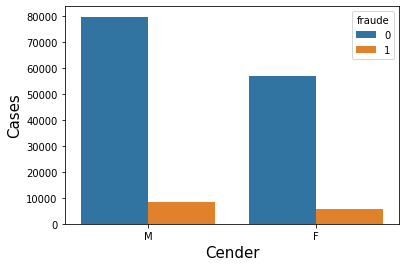

In [17]:
sns.countplot(x = "genero", hue = "fraude", data = fraud_df)
plt.xlabel("Gender", fontsize = 15)
plt.ylabel("Cases", fontsize = 15)

/home/giovani/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Purchase amount')

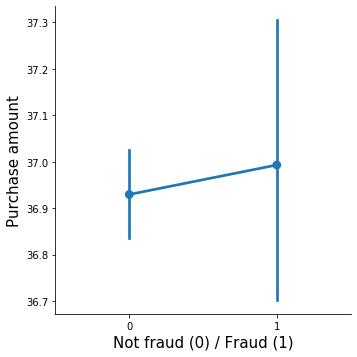

In [18]:
sns.factorplot(x = "fraude", y = "valor", data = fraud_df)
plt.xlabel("Not fraud (0) / Fraud (1)", fontsize = 15)
plt.ylabel("Purchase amount", fontsize = 15)

Text(-5.825000000000003, 0.5, 'Age')

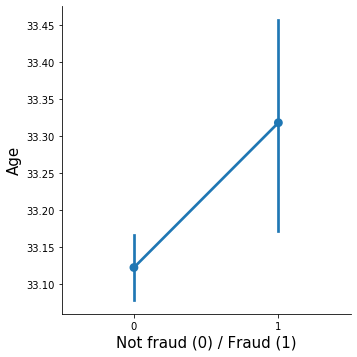

In [19]:
sns.factorplot(x = "fraude", y = "idade", data = fraud_df)
plt.xlabel("Not fraud (0) / Fraud (1)", fontsize = 15)
plt.ylabel("Age", fontsize = 15)

Text(0, 0.5, 'Count')

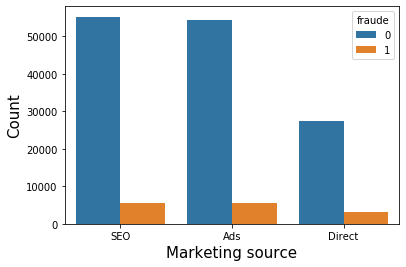

In [20]:
sns.countplot(x = "fonte", hue = "fraude", data = fraud_df)
plt.xlabel("Marketing source", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

In [21]:
sums_f = fraud_df[fraud_df["fraude"] == 1]["fraude"].groupby(fraud_df.pais).sum()
sums_f = sums_f.to_frame().reset_index()

sums_nf = fraud_df[fraud_df["fraude"] == 0]["fraude"].groupby(fraud_df.pais).sum()
sums_nf = sums_nf.to_frame().reset_index()

Text(0, 0.5, 'Countries')

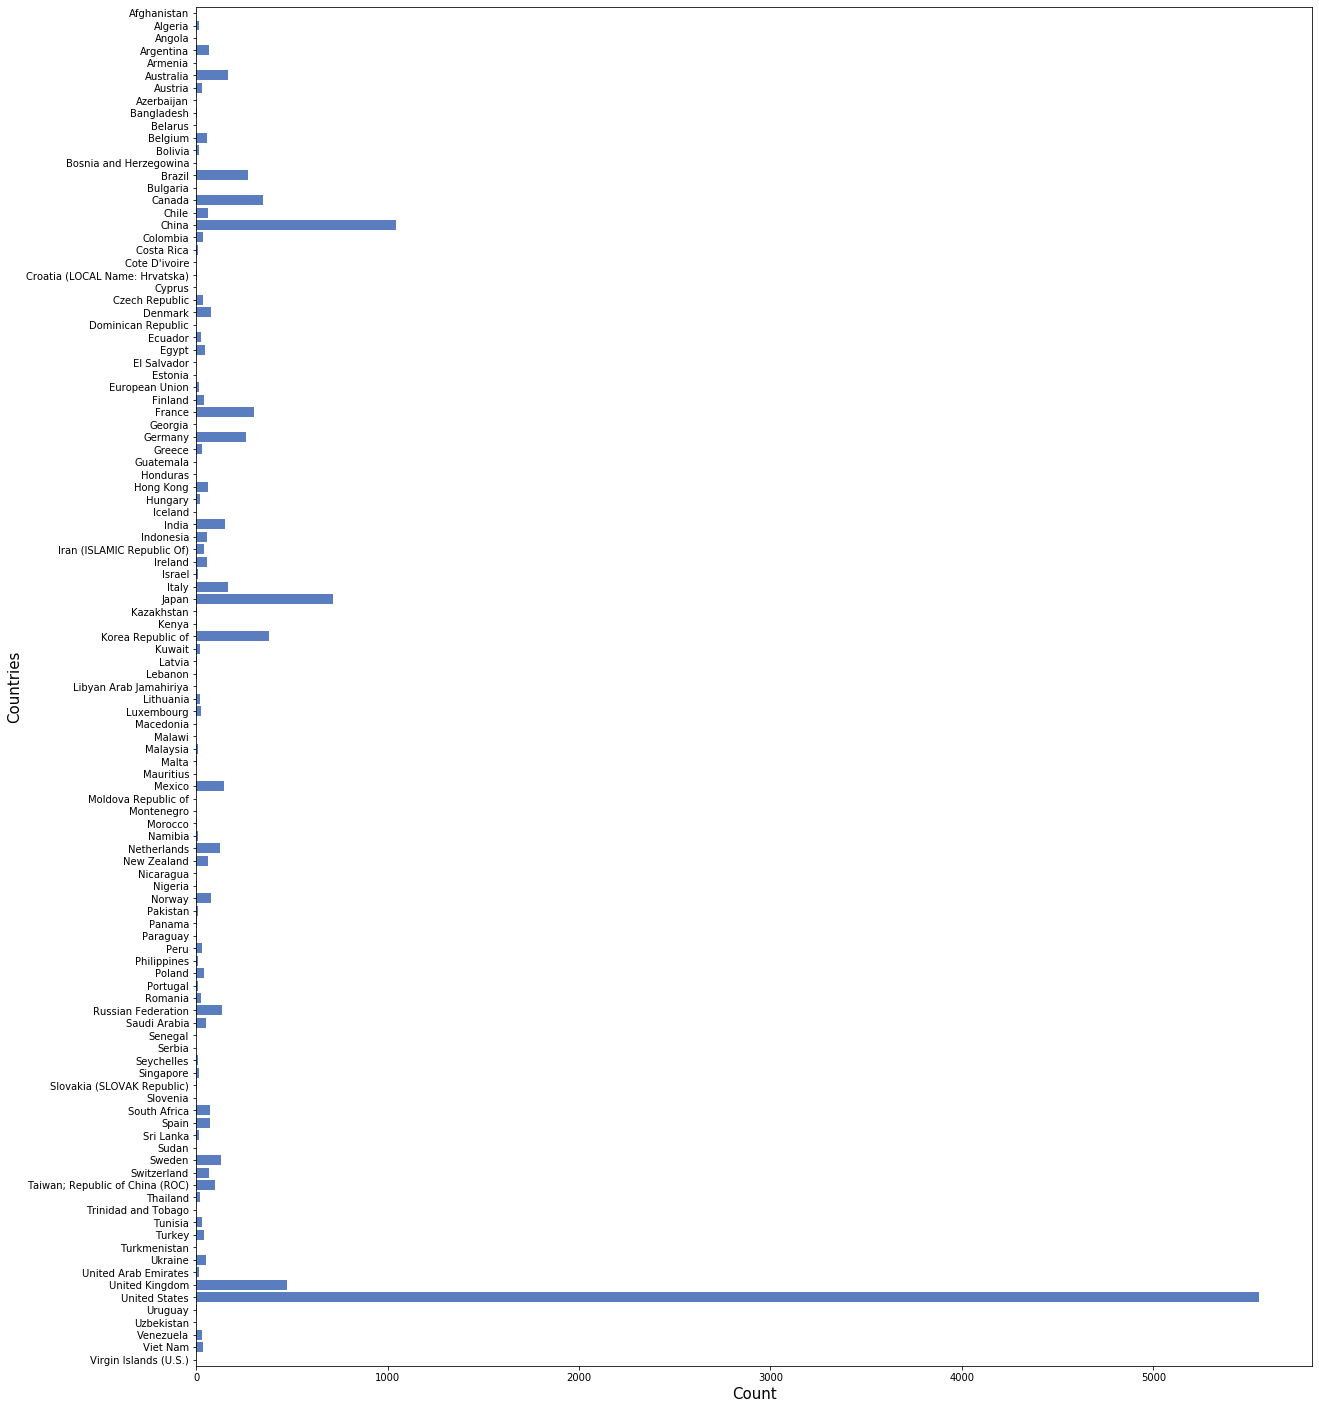

In [22]:
f, ax = plt.subplots(figsize = (20, 25))
sns.set_color_codes("muted")
sns.barplot(x = "fraude", y = "pais", data = sums_f, label = "Total", color = "b")
plt.xlabel("Count", fontsize = 15)
plt.ylabel("Countries", fontsize = 15)

In [23]:
tmp_df = pd.DataFrame(columns = ("fraude", "id_por_dispositivo", "id_por_ip"))
tmp_df["fraude"] = fraud_df["fraude"]

userid_count = fraud_df.groupby("id_dispositivo").id.count()
tmp_df["id_por_dispositivo"] = fraud_df.id_dispositivo.apply(lambda x: userid_count[x])

userid_count2 = fraud_df.groupby("ip").id.count()
tmp_df["id_por_ip"] = fraud_df.ip.apply(lambda x: userid_count2[x])

Text(16.299999999999997, 0.5, 'User ID by IP')

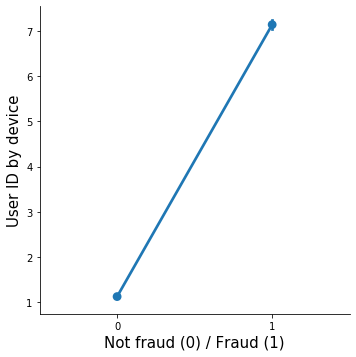

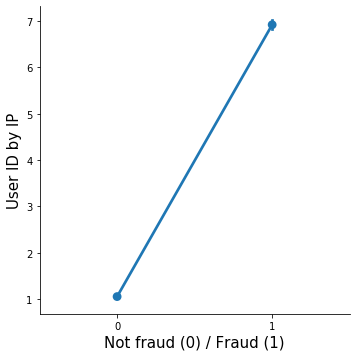

In [24]:
sns.factorplot(x = "fraude", y = "id_por_dispositivo", data = tmp_df)
plt.xlabel("Not fraud (0) / Fraud (1)", fontsize = 15)
plt.ylabel("User ID by device", fontsize = 15)

sns.factorplot(x = "fraude", y = "id_por_ip", data = tmp_df)
plt.xlabel("Not fraud (0) / Fraud (1)", fontsize = 15)
plt.ylabel("User ID by IP", fontsize = 15)

In [25]:
tmp_df["cadastro"] = fraud_df.cadastro.apply(pd.to_datetime)
tmp_df["compra"] = fraud_df.compra.apply(pd.to_datetime)

tmp_df["tempo"] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

Text(-8.825000000000003, 0.5, 'Time between start and purchase (seconds)')

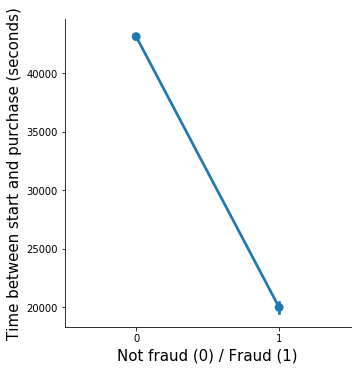

In [26]:
sns.factorplot(x = "fraude", y = "tempo", data = tmp_df)
plt.xlabel("Not fraud (0) / Fraud (1)", fontsize = 15)
plt.ylabel("Time between start and purchase (seconds)", fontsize = 15)

In [27]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,1,1,2015-04-28 21:13:25,2015-05-04 13:54:50,60085
4,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461


Text(0, 0.5, 'Count')

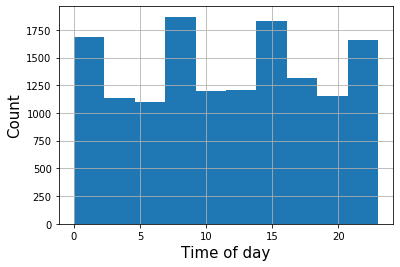

In [28]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Time of day", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

Text(0, 0.5, 'Count')

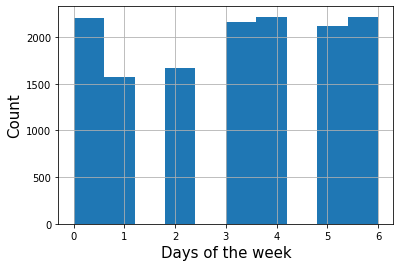

In [29]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Days of the week", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

Text(0, 0.5, 'Count')

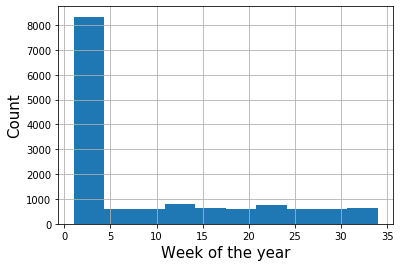

In [30]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Week of the year", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

In [31]:
userid_count3 = fraud_df.groupby("id_dispositivo").id.count()
fraud_df["id_por_dispositivo"] = fraud_df.id_dispositivo.apply(lambda x: userid_count3[x])

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [32]:
userid_count4 = fraud_df.groupby("ip").id.count()
fraud_df["id_por_ip"] = fraud_df.ip.apply(lambda x: userid_count4[x])

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [33]:
fraud_df["media_id"] = (fraud_df.id_por_dispositivo + fraud_df.id_por_ip) * 0.5

fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [34]:
fraud_df.cadastro = fraud_df.cadastro.apply(pd.to_datetime)
fraud_df.compra = fraud_df.compra.apply(pd.to_datetime)

fraud_df["tempo"] = (fraud_df.compra - fraud_df.cadastro).apply(lambda x: x.seconds)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [35]:
pais_dummies = pd.get_dummies(fraud_df.pais, prefix = 'country')
fraud_df = pd.concat([fraud_df, pais_dummies], axis = 1)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


In [36]:
fraud_df.drop(["id", 
               "cadastro", 
               "compra", 
               "id_dispositivo", 
               "ip", 
               "id_por_dispositivo", 
               "id_por_ip",
               "pais",
               "fonte",
               "browser",
               "genero",
               "idade",
               "valor"], axis = 1, inplace = True)

/home/giovani/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0, 0.5, 'Normalized count')

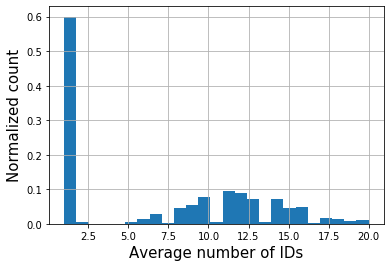

In [37]:
fraud_df[fraud_df["fraude"] == 1].media_id.hist(normed = True, bins = 25)
plt.xlabel("Average number of IDs", fontsize = 15)
plt.ylabel("Normalized count", fontsize = 15)

Text(0, 0.5, 'Normalized count')

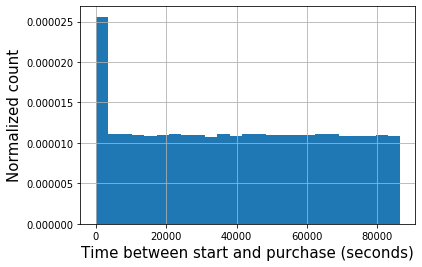

In [38]:
fraud_df.tempo.hist(normed = True, bins = 25)
plt.xlabel("Time between start and purchase (seconds)", fontsize = 15)
plt.ylabel("Normalized count", fontsize = 15)

In [39]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2) * special.erfinv(2 * x - 1))
    
    return new_ser

Text(0, 0.5, 'Normalized count')

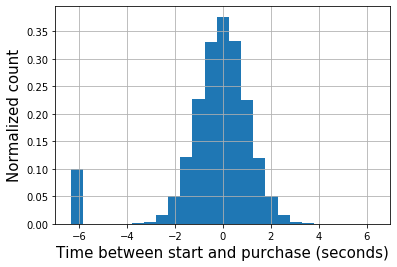

In [40]:
fraud_df["tempo"] = rescale_series(fraud_df.tempo)
fraud_df.tempo.hist(normed = True, bins = 25)
plt.xlabel("Time between start and purchase (seconds)", fontsize = 15)
plt.ylabel("Normalized count", fontsize = 15)

In [41]:
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    
    return new_ser

onehotencoded = [feature for feature in fraud_df.columns if "pais" not in feature and feature != "fraude"]

for col in onehotencoded:
    fraud_df[col] = rescale_series(fraud_df[col])
    
X = fraud_df[ [col for col in fraud_df.columns if col != "fraude" ]]
Y = fraud_df["fraude"]

In [42]:
X.to_csv("X.csv", index = False)
Y.to_csv("Y.csv", index = False)

/home/giovani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [43]:
clf = ExtraTreesClassifier()
_ = clf.fit(X, Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

features [features.importance > np.mean(features.importance)].sort_values(by="importance", ascending = False)

/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,feature,importance
1,tempo,0.736666
0,media_id,0.256976


In [44]:
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size = 0.75, random_state = 23)

Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

In [45]:
IF = IsolationForest(max_samples="auto", contamination = 0.095, random_state = 1)
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF,
                   param_grid,
                   cv = 5,
                   n_jobs = 10,
                   scoring = "f1",
                   verbose = 10)

_ = clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 17.5min
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed: 29.2min remaining: 13.2min
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed: 35.3min remaining:  8.8min
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed: 39.6min remaining:  3.9min
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed: 39.8min finished
/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


              precision    recall  f1-score   support

   anomalous       0.47      0.48      0.48      3546
      normal       0.95      0.95      0.95     34232

    accuracy                           0.90     37778
   macro avg       0.71      0.71      0.71     37778
weighted avg       0.90      0.90      0.90     37778

Area under ROC curve: 0.711


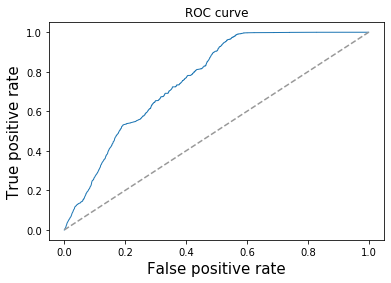

In [46]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval) 
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval, Y_predicted, target_names = ["anomalous", "normal"]))

print("Area under ROC curve: {:0.3f}".format(roc_auc))

IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresold = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw = 1)

plt.plot([0,1],[0,1], '--', color=(0.6, 0.6, 0.6), label = "sorte")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel("False positive rate", fontsize = 15)
plt.ylabel("True positive rate", fontsize = 15)
plt.title("ROC curve", fontsize = 12)

plt.show()

In [47]:
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)

[[ 1689  1857]
 [ 1868 32364]]


In [48]:
X["fraude"] = Y

X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

train_idxs = sample(list(X_normal.index), int(0.7 * X_normal.shape[0]))
X_train = X_normal.loc[train_idxs]

X_testing = X_normal.drop(train_idxs)

X_testing = pd.concat([X_testing, X_anomalias], axis = 0)

X_train = X_train.sample(frac = 1).reset_index(drop = True)
X_testing = X_testing.sample(frac = 1).reset_index(drop = True)

Y_testing = X_testing["fraude"]
X_testing = X_testing[ [col for col in X_testing.columns if col != 'fraude'] ]

X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size = 0.7, random_state = 23)

Y_cv = Y_cv.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

X_train = X_train[ [col for col in X_testing.columns if col != 'fraude'] ]

In [49]:
param_grid = {"nu": np.linspace(0.001, 0.01, 5), "gamma": [0.01, 0.03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"], param_grid["gamma"]))

In [50]:
def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):
    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel = "rbf", nu = nu, gamma = gamma, random_state = 1)
        print("Training model...")
        OCSVM.fit(X_train)
        
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average = "binary")
        
        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM
            remaining_fits -= 1
        
    return f1_max, OCSVM

f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Training model...


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


/home/giovani/anaconda3/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


              precision    recall  f1-score   support

   anomalous       0.94      0.47      0.63      4247
     normais       0.84      0.99      0.91     12325

    accuracy                           0.86     16572
   macro avg       0.89      0.73      0.77     16572
weighted avg       0.87      0.86      0.84     16572

Area under ROC curve: 0.730


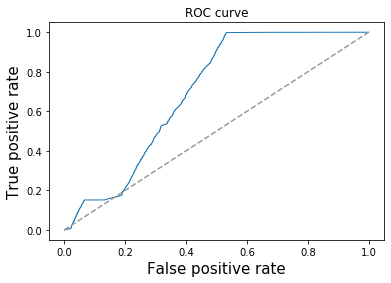

In [51]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval, Y_predicted, target_names = ["anomalous", "normal"]))

print("Area under ROC curve: {:0.3f}".format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, threshold = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw = 1, label = "ROC")
plt.plot([0,1], [0,1], '--', color=(0.6, 0.6, 0.6), label = "sorte")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel("False positive rate", fontsize = 15)
plt.ylabel("True positive rate", fontsize = 15)
plt.title("ROC curve", fontsize = 12)

plt.show()

In [52]:
print(confusion_matrix(Y_eval, Y_predicted))

[[ 2000  2247]
 [  137 12188]]


              precision    recall  f1-score   support

   anomalous       0.96      0.88      0.92      4247
     normais       0.96      0.99      0.97     12325

    accuracy                           0.96     16572
   macro avg       0.96      0.93      0.95     16572
weighted avg       0.96      0.96      0.96     16572

Area under ROC curve: 0.935


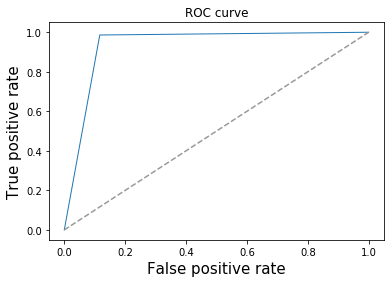

In [53]:
decision_tree = DecisionTreeClassifier(random_state = 1)
dedecision_tree = DecisionTreeClassifier(random_state = 1)
decision_tree.fit(X_dev, Y_dev)

Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval, Y_predicted, target_names = ['anomalous', 'normal']))

print('Area under ROC curve: {:0.3f}'.format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)

plt.plot(fpr, tpr, lw = 1, label = 'ROC')

plt.plot([0,1], [0,1], '--', color = (0.6,0.6,0.6), label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel("False positive rate", fontsize = 15)
plt.ylabel("True positive rate", fontsize = 15)
plt.title("ROC curve", fontsize = 12)

plt.show()

In [54]:
print(confusion_matrix(Y_eval, Y_predicted))

[[ 3752   495]
 [  172 12153]]
